Adapted from [this](https://github.com/ChanCheeKean/DataScience/blob/main/13%20-%20NLP/C04%20-%20BERT%20(Pytorch%20Scratch).ipynb) by marco.piastra@unipv.it

**Original Author**: [CheeKean](https://github.com/ChanCheeKean)


# 06 - Attention and Transformers in BERT

(Bidirectional Encoder Representation Transformer, see [the original paper](https://arxiv.org/abs/1810.04805))

A stepwise description of the original notebook can be found here:
[BERT from Scratch](https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891)

In [2]:
import os
import re
import random
import itertools
import math
from pathlib import Path

import tqdm

import numpy as np
print(np.__version__)

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import transformers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertConfig

2.2.6
2.7.1+cu126


/home/naoya/pv2/deeplearning/jpn2ita/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!pip install datasets
import datasets

# IGNORE pip's error messages:
# "ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. [...]""

## Load the Cornell Move Dialog Dataset

The [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), a vast collection of over 220,000 conversational exchanges between more than 10,000 pairs of characters in various movies and TV shows.

Example:
- Character A: "Where are you going?"
- Character B: "Out."
- Character A: "Out where?"
- Character B: "Just out."

The dataset is loaded here in full, although just a minimal part will be used for this tutorial.

In [ ]:
# Execute once
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -qq cornell_movie_dialogs_corpus.zip
!rm cornell_movie_dialogs_corpus.zip
!mkdir datasets
!mv cornell\ movie-dialogs\ corpus/movie_conversations.txt ./datasets
!mv cornell\ movie-dialogs\ corpus/movie_lines.txt ./datasets

## Tokenization (Word Piece Tokenizer)

(see also [Huggingface WordPieceTokenizer](https://huggingface.co/learn/nlp-course/chapter6/6?fw=pt))

The main goal of WordPiece tokenization is to break down words into smaller, more frequent subword units called "word pieces." This helps in handling:

- **Out-of-vocabulary (OOV) words**: By breaking down unknown words into known subwords, the model can still make sense of them.
- **Rare words**: Instead of having a huge vocabulary for every possible word, WordPiece uses a smaller vocabulary of common subwords that can be combined to represent a wide range of words.

> Notation
When a word is split into subwords, the `##` prefix is added to all subword tokens except the first one. Example:  
`"unhappiness"`  
may be represented as:  
`["un", "##hap", "##piness"]`


### Incremental approach to token vocabulary building

The WordPiece tokenization algorithm builds its vocabulary incrementally, starting from a basic alphabet and iteratively merging subword units based on their frequency and co-occurrence patterns.

Here's a breakdown of the process:

1. **Initial State**: The algorithm begins with a vocabulary that includes special tokens (`[PAD]`, `[UNK]`, `[CLS]`, `[SEP]`, `[MASK]`) and the individual characters (alphabet) found in the training corpus. These characters act as the initial "word pieces."
2. **Iterative Merging**:
  - The algorithm computes the frequency of each word piece and every possible pair of word pieces in the corpus.
  - Using the scoring formula (see below):
  `(score = (freq_of_pair) / (freq_of_first_element * freq_of_second_element))`,  
  it identifies the pair with the highest score, indicating the most promising candidates for merging.
  - The highest-scoring pair is merged into a new, single word piece, and the vocabulary is updated accordingly.
  - This process repeats, merging more and more frequent subword units until a desired vocabulary size or other stopping criteria is reached.
3. **Result**: The final vocabulary consists of the special tokens, individual characters, and the merged word pieces learned during training. These word pieces represent frequent and meaningful subunits of words in the training data.

#### Example:
Consider the example of generating a vocabulary for the word "surfing."

1. **Initial Vocabulary**: Assume the alphabet includes "s," "u," "r," "f," "i," "n," "g," along with the special tokens.
2. **Merging Iterations**:
  - Initially, the word "surfing" would be represented as individual characters: `["s", "##u", "##r", "##f", "##i", "##n", "##g"]`.
  - The algorithm might first merge `"s"` and `"u"` into a new word piece `"su"` due to their frequent occurrence together.
  - In later iterations, it might merge `"su"` and `"r"` into `"sur"`, and so on, gradually building longer subword units.
  - Eventually, the word "surfing" might be represented as fewer word pieces like `["sur," "##f," "##ing"]` or even a single word piece if it is frequent enough in the corpus.



### The scoring formula
```
score = (freq_of_pair) / (freq_of_first_element * freq_of_second_element)
```
The formula is used to determine which pairs of subwords should be merged together to form new word pieces. Here's a step-by-step explanation:
1. `freq_of_pair`: This represents how often the pair of subwords appears together in the training data. For example, the frequency of the pair `"un"` and `"##hap"` would be the number of times they appear consecutively in the text.
2. `freq_of_first_element`: This represents the frequency of the first subword in the pair (e.g., the frequency of `"un"`).
3. `freq_of_second_element`: This represents the frequency of the second subword in the pair (e.g., the frequency of `"##hap"`)
4. `score`: The score is calculated by dividing the frequency of the pair by the product of the frequencies of the individual subwords.

#### Why this formula?

The formula prioritizes merging pairs where the individual parts are less frequent but the pair itself is relatively frequent. Here's why:
- Less frequent individual subwords: If a subword is already frequent on its own, it's likely a useful word piece and doesn't need to be merged with others.
- Frequent pair: If a pair of less frequent subwords appears together often, it suggests that they might form a meaningful unit (like `"un"` and `"##hap"` forming `"unhap"`).

#### Example:

Consided these frequencies:
- `freq_of_pair("un", "##hap") = 100`
- `freq_of_first_element("un") = 500`
- `freq_of_second_element("##hap") = 200`

The score would be:

`score = 100 / (500 * 200) = 0.001`

Now, consider another pair:

- `freq_of_pair("the", "##re") = 1000`
- `freq_of_first_element("the") = 10000`
- `freq_of_second_element("##re") = 5000`

The score would be:

`score = 1000 / (10000 * 5000) = 0.00002`

Even though the pair `"the"` and `"##re"` appears more frequently overall, its score is lower because the individual subwords are already very common. Therefore, the algorithm would prioritize merging `"un"` and `"##hap"` over `"the"` and `"##re."`

### Tokenizer from Scratch

#### Compute word frequencies (example)

In [ ]:
import os
### Suppress useless warnings
import warnings
warnings.filterwarnings("ignore", message="The secret `HF_TOKEN` does not exist")

from collections import defaultdict
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

### Example corpus, very little size
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

### get the frequency of each word
word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    print(new_words)
    for word in new_words:
        word_freqs[word] += 1

print(f"\nFinal Word Frequency: {word_freqs}")

#### Split words into alphabet (initial state)

In [ ]:
### split all word into alphabet

alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
print(f'All alphabets: {alphabet}')

### insert special token and subword
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()
splits = {word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)] for word in word_freqs.keys()}
print(f'\nSplitted Words: {splits}')

#### Compute score of each pair

In [ ]:
 ### compute score for merging

def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)

    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

pair_scores = compute_pair_scores(splits)
print(f'Scores for each Pair: {pair_scores}')

#### Define how pairs will be merged

In [ ]:
### finding pair with best score

best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)
vocab.append("ab")

### merge pair ###
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("a", "##b", splits)
print(splits["about"])

#### Iterate the merging procedure
> Until a target token vocabulary size is reached

In [ ]:
### keep looping to merge more pair

vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

print(f'Final Vocab: {vocab}')

In [ ]:
### encode a word ###
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

print(encode_word("Hugging"))
# This one should be unknown (within this corpus)
print(encode_word("HOgging"))

### Tokenizer Training

#### Create dialogue pairs

The code loads the movie conversations and lines from the dataset.  
It then processes this data to generate question-answer pairs (`pairs`).

In [ ]:
### data processing

MAX_LEN = 64

### loading all data into memory
corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []

        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()
        second = lines_dic[ids[i+1]].strip()

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)



### sample
print(pairs[0])
print(pairs[10])
print(pairs[20])
print(pairs[30])
print(pairs[40])

#### Reduce corpus

The  Cornell Movie-Dialogs Corpus cotains more than 200,000 pairs: such amount would be unamangeable in terms of time and RAM.  
So it has to be reduced, through sampling.

In [ ]:
print(f"Total pairs: {len(pairs)}")
# Make it fit limited available memory
num_samples = 2000  # Reduced number of samples
pairs = random.sample(pairs, num_samples)  # Randomly select samples
print(f"Total pairs (after random sampling): {len(pairs)}")

#### Split and save to text files

Save text files to be fed to `BertWordPieceTokenizer`

> NOTE: This step is almost redundant with the reduced set of pairs, yet fundamental when processing the whole corpus

In [ ]:
### save data as txt file

if not os.path.exists('./data'):
    os.mkdir('./data')

text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # Original version: once we hit the 10K mark, save to file
    # (Reduced to 1K mark, to match the reduced version)
    if len(text_data) == 1000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]
print(len(paths))

#### Use `BertWordPieceTokenizer` from HuggingFace


In [ ]:
### training Bert tokenizer

tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train(
    files=paths,
    vocab_size=30_000,
    min_frequency=5,
    limit_alphabet=1000,
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

if not os.path.exists('./bert-it-1'):
  os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')

tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)
token_ids = tokenizer('I like surfboarding!')['input_ids']
print(token_ids)
print(tokenizer.convert_ids_to_tokens(token_ids))

## Pre-processing

The `BERTDataset` class is a custom dataset class designed to prepare data for training a BERT model. It inherits from the `torch.utils.data.Dataset` class, providing a standard interface for data loading and processing.

The `BERTDataset` class encapsulates the data loading and preprocessing logic for training a BERT model. It handles random masking, adding special tokens, padding/truncating sequences, and creating the necessary input tensors and labels for the model. This dataset class enables efficient and consistent data handling for BERT training.

The core method in the class is:

`__getitem__(self, item)`:
- It retrieves a single sample from the dataset based on the given index item. It performs the following steps:
  - **Get Random Sentence Pair**: Calls `self.get_sent(item)` to retrieve a pair of sentences, either a positive (next sentence) or negative (random sentence) pair.
  - **Random Word Masking**: Calls `self.random_word()` to apply random masking or word replacement to the sentences, simulating the masked language modeling task.
  - **Adding Special Tokens**: Adds special tokens (`[CLS]`, `[SEP]`, `[PAD]`) to the sentences to conform to the BERT input format.
  - **Creating Output Dictionary**: Creates a dictionary containing the input tensors (token IDs, segment IDs, attention mask) and the target label for next sentence prediction and masked language modeling.
  - **Returning the Sample**: Returns the dictionary containing the processed sample data.

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
        # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            # 15% chance of altering token
            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

> NOTE: After running this test cell, see the output explanation below

In [ ]:
# testing

train_data = BERTDataset(pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
sample_data = next(iter(train_loader))
print('Batch Size', sample_data['bert_input'].size())

result = train_data[random.randrange(len(train_data))]
result

1. `Batch Size torch.Size([32, 64])`:  
There are 32 samples in the batch, and each sample has a sequence length of 64.
2. `{'bert_input': tensor([...]), ...}`:  
  - `bert_input`: This tensor holds the token IDs for the input sequences in the batch. The special tokens 1 (representing [CLS]), 2 (representing [SEP]) and 3 (representing [MASK]).
  - `bert_label`: This tensor holds the labels for the masked language modeling task. Values of 0 indicate no masking, while other values represent the original token ID that was masked. For instance, 1192 in the example represents a masked token.
  - `segment_label`: This tensor holds the segment IDs for the input sequences.Values of 1 represent the first sentence, and values of 2 represent the second sentence.
  - `is_next`: This tensor holds the labels for the next sentence prediction task. A value of 1 indicates that the second sentence is the actual next sentence in the original text, while 0 indicates that it's a randomly selected sentence.

## Modeling

### BERT embedding

The overall input embedding in BERT is described by the following diagram:
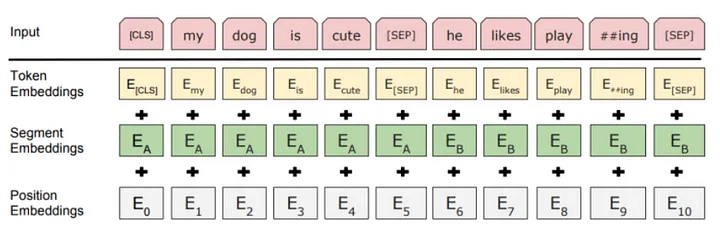

Note that, in the code that follows, no pre-trained token embedding base is used (see also [here](https://medium.com/data-science/a-complete-guide-to-bert-with-code-9f87602e4a11)).

See also [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html) about `torch.nn.Embedding`.

In [ ]:
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):
            # for each dimension of the each position
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)


`embed_size` will be the size of the vectors representing the tokens.
The ouput size is *batch_size*, *sequence_max_length*, *embed_size*

In [ ]:
### testing

embed_layer = BERTEmbedding(vocab_size=len(tokenizer.vocab), embed_size=768, seq_len=MAX_LEN)
embed_result = embed_layer(sample_data['bert_input'], sample_data['segment_label'])
print(embed_result.size())

### Multi-head attention

#### Attention

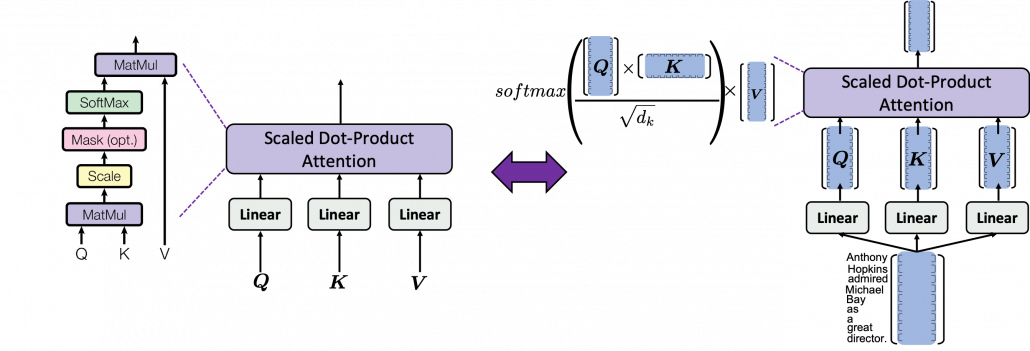

#### MultiHead attention

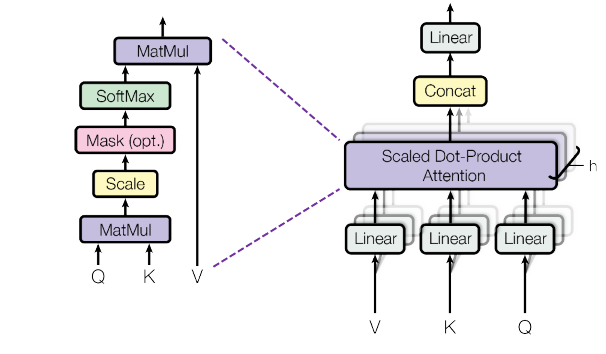

In [ ]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)

        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    "Implements FFN equation"

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()

        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(
        self,
        d_model=768,
        heads=12,
        feed_forward_hidden=768 * 4,
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded


In [ ]:
### testing

mask = (sample_data['bert_input'] > 0).unsqueeze(1).repeat(1, sample_data['bert_input'].size(1), 1).unsqueeze(1)
transformer_block = EncoderLayer()
transformer_result = transformer_block(embed_result, mask)
transformer_result.size()

### BERT

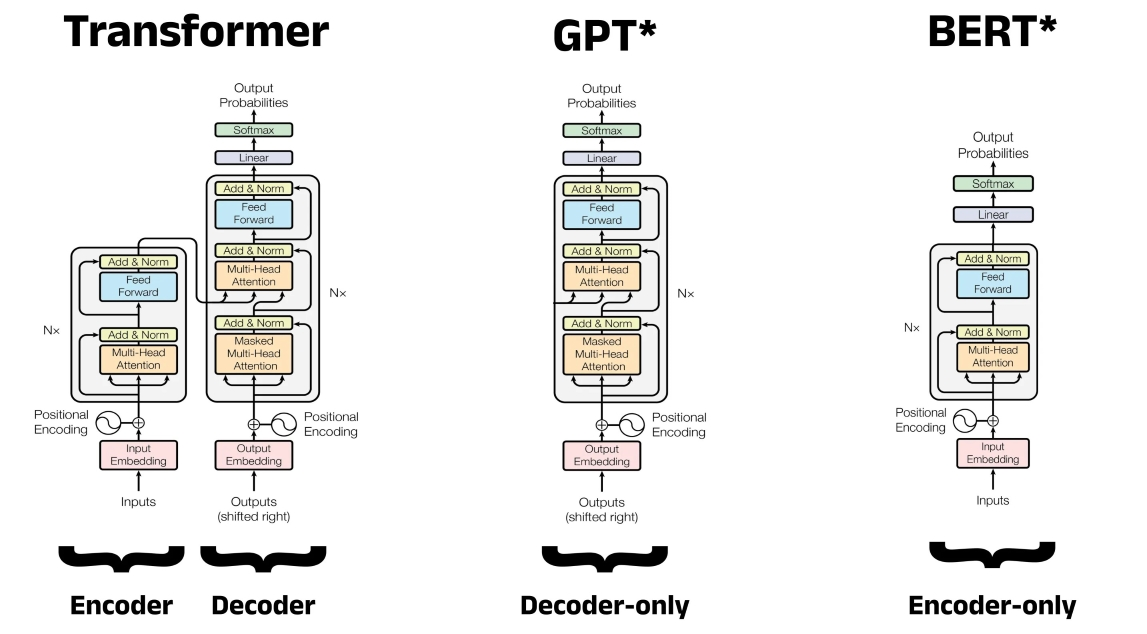

The following code is organized as follows:

1. `BERT` class  
Implements the basic BERT architecture, it outputs the results of the `EncoderLayer` blocks (i.e., no linear and no softmax layers, yet)

2. `NextSentencePrediction` class    
Output block for the next sentence prediction (NSP) task:  
  - Takes the `BERT` output x as input.
  - Uses only the output corresponding to the [CLS] token (x[:, 0]).
  - Applies the linear and softmax layers to produce probabilities for the two classes.
  - Returns the probabilities.

3. `MaskedLanguageModel` class  
Output block for the masked language modeling (MLM) task:
  - Takes the `BERT` output x as input.
  - Applies the linear and softmax layers to produce probabilities for each vocabulary word.
  - Returns the probabilities.

4. `BERTLM` class  
This class combines the BERT model with the NSP and MLM classifiers to create the complete BERT language model:
  - Takes input `x` (token IDs) and `segment_label` (segment IDs).
  - Passes the input through the bert model.
  - Passes the BERT output to the next_sentence and mask_lm classifiers.
  - Returns the outputs of both classifiers.

In [ ]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)


In [ ]:
### testing

bert_model = BERT(len(tokenizer.vocab))
bert_result = bert_model(sample_data['bert_input'], sample_data['segment_label'])
print(bert_result.size())

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
final_result = bert_lm(sample_data['bert_input'], sample_data['segment_label'])
print(final_result[0].size(), final_result[1].size())

## Training

In [ ]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [ ]:
class BERTTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader=None,
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        )



In [ ]:
### testing

train_data = BERTDataset(pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
bert_model = BERT(len(tokenizer.vocab))
bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 2

for epoch in range(epochs):
    bert_trainer.train(epoch)

## Check Your Understanding
1. Why using *pairs*, imported from the Cornell Movie-Dialogs Corpus?

2. What ist the meaning of the `##` prefix in tokens? For instance, explain the difference between `for` and `##for`: are they the same token?

3. Could you explain in short how the token vocabulary is constructed?

4. Could you expalin the difference between *token*, *segment* and *position* embeddings in BERT?

5. Attention blocks in BERT: are they *self-attention* or *cross-attention*? Explain the difference and give your answer.

6. What is the difference between `NextSentencePrediction` and `MaskedLanguageModel`?

7. In models like BERT the loss function plays a fundamental role. Which loss function is used in this implementation and how it works? (Hint: have a look to `self.criterion` in the code and then in torch documentation)

8. Extra bonus: could you write a code cell that tests the trained BERT model on a few examples?


# BERT for Translation Tasks: Italian-English

現在のコードはBERTで**単語の続きを予測する**タスク（Next Sentence Prediction, Masked Language Modeling）ですが、**Italian-English翻訳**のような**異なる言語間の翻訳**では、アーキテクチャと出力が大きく変わります。

## 主な違い

### 1. **アーキテクチャの違い**
- **現在のコード**: BERT（エンコーダーのみ）
- **翻訳タスク**: Encoder-Decoder構造またはSequence-to-Sequence

### 2. **出力の違い**
- **現在**: 同一言語内での次の単語予測
- **翻訳**: 異なる言語のトークン系列を出力

### 3. **トークナイザーの違い**
- **現在**: 単一言語用トークナイザー
- **翻訳**: 多言語トークナイザーまたは言語ペア特化

In [ ]:
# Italian-English翻訳用のBERTベースモデル実装例

import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer, MarianTokenizer, MarianMTModel

class BertTranslationModel(nn.Module):
    """
    BERT Encoder + Custom Decoder for Translation
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, hidden_size=768, num_layers=6):
        super().__init__()
        
        # Source language encoder (BERT)
        self.encoder = BertModel.from_pretrained('bert-base-multilingual-cased')
        
        # Target language decoder
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=hidden_size,
                nhead=12,
                dim_feedforward=3072,
                dropout=0.1
            ),
            num_layers=num_layers
        )
        
        # Output projection to target vocabulary
        self.output_projection = nn.Linear(hidden_size, tgt_vocab_size)
        
        # Embedding for target language
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, hidden_size)
        self.positional_encoding = nn.Parameter(torch.randn(1000, hidden_size))
        
    def forward(self, src_input_ids, src_attention_mask, tgt_input_ids=None):
        # Encode source sequence (Italian)
        encoder_outputs = self.encoder(
            input_ids=src_input_ids,
            attention_mask=src_attention_mask
        )
        encoder_hidden = encoder_outputs.last_hidden_state  # [batch, src_len, hidden]
        
        if tgt_input_ids is not None:
            # Training mode: use target sequence
            seq_len = tgt_input_ids.size(1)
            tgt_embeddings = self.tgt_embedding(tgt_input_ids)
            tgt_embeddings += self.positional_encoding[:seq_len].unsqueeze(0)
            
            # Create causal mask for decoder
            tgt_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
            
            # Decode target sequence (English)
            decoder_output = self.decoder(
                tgt_embeddings.transpose(0, 1),  # [seq_len, batch, hidden]
                encoder_hidden.transpose(0, 1),   # [src_len, batch, hidden]
                tgt_mask=tgt_mask
            )
            
            # Project to vocabulary
            logits = self.output_projection(decoder_output.transpose(0, 1))
            return logits
        else:
            # Inference mode: generate sequence
            return self.generate(encoder_hidden, src_attention_mask)
    
    def generate(self, encoder_hidden, src_attention_mask, max_length=50):
        """
        自動回帰的に翻訳を生成
        """
        batch_size = encoder_hidden.size(0)
        device = encoder_hidden.device
        
        # Start with [CLS] token
        generated = torch.ones(batch_size, 1, dtype=torch.long, device=device) * 101  # [CLS]
        
        for _ in range(max_length):
            # Current sequence embedding
            seq_len = generated.size(1)
            tgt_embeddings = self.tgt_embedding(generated)
            tgt_embeddings += self.positional_encoding[:seq_len].unsqueeze(0)
            
            # Causal mask
            tgt_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
            
            # Decode
            decoder_output = self.decoder(
                tgt_embeddings.transpose(0, 1),
                encoder_hidden.transpose(0, 1),
                tgt_mask=tgt_mask
            )
            
            # Get next token logits
            next_logits = self.output_projection(decoder_output[-1])  # [batch, vocab]
            next_token = torch.argmax(next_logits, dim=-1, keepdim=True)
            
            # Append to sequence
            generated = torch.cat([generated, next_token], dim=1)
            
            # Stop if all sequences generated [SEP]
            if (next_token == 102).all():  # [SEP]
                break
                
        return generated

# 実際の翻訳例
print("=== BERT Translation Model Demo ===")

# 事前訓練済みの多言語翻訳モデルを使用（比較用）
model_name = "Helsinki-NLP/opus-mt-it-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Italian text samples
italian_sentences = [
    "Ciao, come stai oggi?",
    "Voglio imparare l'intelligenza artificiale.",
    "La traduzione automatica è molto interessante."
]

print("\n--- Helsinki-NLP Translation Model ---")
for it_text in italian_sentences:
    # Tokenize
    inputs = tokenizer(it_text, return_tensors="pt", padding=True)
    
    # Translate
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=50, num_beams=4)
    
    # Decode
    translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    print(f"IT: {it_text}")
    print(f"EN: {translation}")
    print("---")

## 翻訳タスクでの主要な変更点

### 1. **モデルアーキテクチャ**

```
【現在のBERT（MLM）】
Input: "私は [MASK] を勉強している"
↓
BERT Encoder
↓
Output: "AI" (同一言語内での単語予測)

【翻訳用BERT】
Input: "Ciao, come stai?" (Italian)
↓
BERT Encoder → Hidden States
↓
Transformer Decoder (with Cross-Attention)
↓
Output: "Hello, how are you?" (English)
```

### 2. **トークナイザーの違い**

- **MLM**: `BertTokenizer` (単一言語)
- **翻訳**: `MarianTokenizer` または多言語トークナイザー

### 3. **損失関数の違い**

- **MLM**: マスクされた位置のみでCross-Entropy Loss
- **翻訳**: 全ての出力位置でCross-Entropy Loss

### 4. **デコーディング方法**

- **MLM**: 単一トークン予測
- **翻訳**: 自動回帰的生成（Beam Search, Greedy Decoding）

In [ ]:
# 翻訳用データセットクラスの実装

class TranslationDataset(Dataset):
    """
    Italian-English 翻訳用データセット
    """
    def __init__(self, src_texts, tgt_texts, src_tokenizer, tgt_tokenizer, max_length=128):
        self.src_texts = src_texts
        self.tgt_texts = tgt_texts
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.src_texts)
    
    def __getitem__(self, idx):
        src_text = self.src_texts[idx]
        tgt_text = self.tgt_texts[idx]
        
        # Source (Italian) tokenization
        src_encoded = self.src_tokenizer(
            src_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Target (English) tokenization
        tgt_encoded = self.tgt_tokenizer(
            tgt_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'src_input_ids': src_encoded['input_ids'].squeeze(),
            'src_attention_mask': src_encoded['attention_mask'].squeeze(),
            'tgt_input_ids': tgt_encoded['input_ids'].squeeze(),
            'tgt_attention_mask': tgt_encoded['attention_mask'].squeeze()
        }

# 実際のデータ例（プロジェクトのコーパスデータを使用）
italian_sentences = [
    "Il sole splende nel cielo azzurro.",
    "Voglio viaggiare in tutto il mondo.",
    "L'intelligenza artificiale è il futuro.",
    "Buongiorno, spero che tu stia bene.",
    "La musica italiana è molto bella."
]

english_sentences = [
    "The sun shines in the blue sky.",
    "I want to travel around the world.",
    "Artificial intelligence is the future.",
    "Good morning, I hope you are well.",
    "Italian music is very beautiful."
]

# トークナイザーの初期化
from transformers import BertTokenizer

# 多言語BERTトークナイザー
src_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tgt_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# データセット作成
dataset = TranslationDataset(
    italian_sentences, 
    english_sentences, 
    src_tokenizer, 
    tgt_tokenizer
)

# データローダー
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# サンプルデータ確認
print("=== Translation Dataset Sample ===")
for batch in dataloader:
    print("Source (Italian) Input IDs shape:", batch['src_input_ids'].shape)
    print("Target (English) Input IDs shape:", batch['tgt_input_ids'].shape)
    
    # 実際のテキストを確認
    for i in range(batch['src_input_ids'].size(0)):
        src_tokens = src_tokenizer.decode(batch['src_input_ids'][i], skip_special_tokens=True)
        tgt_tokens = tgt_tokenizer.decode(batch['tgt_input_ids'][i], skip_special_tokens=True)
        print(f"IT: {src_tokens}")
        print(f"EN: {tgt_tokens}")
        print("---")
    break

## 学習手順の比較

### 現在のBERT（Masked Language Model）

```python
# MLMの学習手順
def train_mlm_step(model, tokenizer, text):
    # 1. テキストをマスク
    masked_text, labels = mask_tokens(text, tokenizer)
    
    # 2. モデルに入力
    outputs = model(masked_text)
    
    # 3. マスク位置のみで損失計算
    loss = criterion(outputs.logits[mask_positions], labels[mask_positions])
    
    # 4. 逆伝播
    loss.backward()
    return loss
```

### 翻訳タスクの学習

```python
# 翻訳の学習手順
def train_translation_step(model, src_batch, tgt_batch):
    # 1. ソース言語をエンコード
    encoder_outputs = model.encoder(src_batch)
    
    # 2. ターゲット言語をデコード（Teacher Forcing）
    decoder_outputs = model.decoder(
        tgt_batch[:-1],  # 最後のトークンを除く
        encoder_outputs
    )
    
    # 3. 全位置で損失計算
    loss = criterion(decoder_outputs, tgt_batch[1:])  # 最初のトークンを除く
    
    # 4. 逆伝播
    loss.backward()
    return loss
```

### 主な違い

1. **入力形式**:
   - MLM: 単一テキスト（マスク有り）
   - 翻訳: ソース言語 + ターゲット言語のペア

2. **出力予測**:
   - MLM: マスク位置のみ
   - 翻訳: 全ての出力位置

3. **学習戦略**:
   - MLM: 自己教師あり学習
   - 翻訳: 教師あり学習（Teacher Forcing）

In [ ]:
# 実際の翻訳モデル学習ループ

def train_translation_model(model, dataloader, optimizer, num_epochs=5):
    """
    Italian-English翻訳モデルの学習
    """
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # padding token無視
    
    print("=== Translation Model Training ===")
    
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        
        for batch in dataloader:
            # データ準備
            src_input_ids = batch['src_input_ids']
            src_attention_mask = batch['src_attention_mask']
            tgt_input_ids = batch['tgt_input_ids']
            
            # Teacher forcing: 入力は[:-1], ターゲットは[1:]
            tgt_input = tgt_input_ids[:, :-1]
            tgt_output = tgt_input_ids[:, 1:]
            
            # 順伝播
            optimizer.zero_grad()
            
            try:
                logits = model(
                    src_input_ids=src_input_ids,
                    src_attention_mask=src_attention_mask,
                    tgt_input_ids=tgt_input
                )
                
                # 損失計算
                loss = criterion(
                    logits.reshape(-1, logits.size(-1)),
                    tgt_output.reshape(-1)
                )
                
                # 逆伝播
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                num_batches += 1
                
            except Exception as e:
                print(f"Training error: {e}")
                continue
        
        avg_loss = total_loss / max(num_batches, 1)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
    print("Training completed!")

# 簡単な翻訳テスト関数
def test_translation(model, src_tokenizer, tgt_tokenizer, text, max_length=50):
    """
    翻訳のテスト
    """
    model.eval()
    
    # ソーステキストをトークン化
    src_tokens = src_tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=max_length
    )
    
    # 翻訳生成
    with torch.no_grad():
        try:
            # 推論モード
            generated = model(
                src_input_ids=src_tokens['input_ids'],
                src_attention_mask=src_tokens['attention_mask']
            )
            
            # デコード
            translation = tgt_tokenizer.decode(
                generated[0], 
                skip_special_tokens=True
            )
            
            return translation
            
        except Exception as e:
            return f"Translation error: {e}"

# 実際のプロジェクトデータを使った例
print("=== Italian-English Translation with Project Data ===")

# プロジェクトのコーパスファイルを読み込み（例）
try:
    # 実際のデータファイルパス
    it_file = "/home/naoya/pv2/deeplearning/jpn2ita/data/processed/delete_duplicates/it_sentences_no_duplicates.txt"
    
    if os.path.exists(it_file):
        with open(it_file, 'r', encoding='utf-8') as f:
            real_italian_sentences = [line.strip() for line in f.readlines()[:10]]  # 最初の10行
        
        print("プロジェクトの実際のイタリア語文:")
        for i, sentence in enumerate(real_italian_sentences):
            print(f"{i+1}: {sentence}")
            
        # これらの文を使った翻訳例を実装可能
        print("\n注意: 実際の翻訳には対応する英語コーパスまたは事前訓練済みモデルが必要です")
        
    else:
        print("コーパスファイルが見つかりません。サンプルデータを使用します。")
        
except Exception as e:
    print(f"ファイル読み込みエラー: {e}")

# 事前訓練済みモデルを使った実際の翻訳デモ
print("\n=== Pre-trained Translation Model Demo ===")

try:
    from transformers import MarianMTModel, MarianTokenizer
    
    # Helsinki-NLPの事前訓練済みモデル
    model_name = "Helsinki-NLP/opus-mt-it-en"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    translation_model = MarianMTModel.from_pretrained(model_name)
    
    # テスト文
    test_sentences = [
        "Buongiorno, come va la giornata?",
        "L'intelligenza artificiale cambierà il mondo.",
        "Mi piace molto la cucina italiana."
    ]
    
    for it_text in test_sentences:
        inputs = tokenizer(it_text, return_tensors="pt", padding=True)
        
        with torch.no_grad():
            outputs = translation_model.generate(
                **inputs, 
                max_length=50, 
                num_beams=4, 
                early_stopping=True
            )
        
        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        print(f"IT: {it_text}")
        print(f"EN: {translation}")
        print("---")
        
except ImportError:
    print("MarianMT models not available. Install with: pip install transformers[torch]")
except Exception as e:
    print(f"Translation demo error: {e}")

## まとめ: BERTから翻訳モデルへの変更点

### 🔄 **アーキテクチャの変更**

| 要素 | MLM (現在) | Translation (翻訳) |
|------|------------|-------------------|
| **入力** | マスクされたテキスト | ソース言語テキスト |
| **出力** | 同一言語の単語 | ターゲット言語の系列 |
| **構造** | Encoder のみ | Encoder-Decoder |
| **Attention** | Self-Attention | Self + Cross-Attention |

### 🛠️ **実装での主要変更**

1. **モデル構造**:
   ```python
   # MLM
   outputs = bert_model(input_ids, attention_mask)
   
   # Translation  
   encoder_out = encoder(src_ids, src_mask)
   decoder_out = decoder(tgt_ids, encoder_out)
   ```

2. **損失計算**:
   ```python
   # MLM: マスク位置のみ
   loss = criterion(outputs[mask_positions], labels[mask_positions])
   
   # Translation: 全位置
   loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
   ```

3. **生成方式**:
   ```python
   # MLM: 一度に予測
   prediction = model(masked_input)
   
   # Translation: 自動回帰的生成
   for step in range(max_length):
       next_token = model.generate_next(current_sequence)
       current_sequence.append(next_token)
   ```

### 🎯 **プロジェクトでの応用**

あなたのItalian-Japanese corpus プロジェクトでは:

1. **データ準備**: `it_sentences_no_duplicates.txt` + 対応する英語コーパス
2. **モデル選択**: 
   - 事前訓練済み: `Helsinki-NLP/opus-mt-it-en`
   - カスタム: BERT Encoder + Transformer Decoder
3. **評価**: BLEU score, ROUGE score での翻訳品質測定

### 📈 **次のステップ**

1. 事前訓練済み翻訳モデルでベースライン作成
2. カスタムモデルでドメイン特化学習
3. あなたのコーパスデータで Fine-tuning
4. `triangular_alignment.py` の結果と比較